Read the vision transformer paper here: https://arxiv.org/pdf/2010.11929.pdf

In [2]:
import torch 
import torchvision 
from torchvision import transforms

import matplotlib.pyplot as plt

from going_modular import engine, data_setup
from helper_functions import set_seeds, download_data, plot_loss_curves

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(
    source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
    destination="pizza_steak_sushi"
)
image_path

[INFO] data\pizza_steak_sushi directory exists, skipping download.


WindowsPath('data/pizza_steak_sushi')

In [5]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

In [6]:
IMG_SIZE = 224

manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
manual_transforms

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)

In [7]:
BATCH_SIZE = 32

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE
)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x20888095f10>,
 ['pizza', 'steak', 'sushi'])

In [8]:
image_batch, label_batch = next(iter(train_dataloader))
image, label = image_batch[0], label_batch[0]
image.shape, label

(torch.Size([3, 224, 224]), tensor(2))

(-0.5, 223.5, 223.5, -0.5)

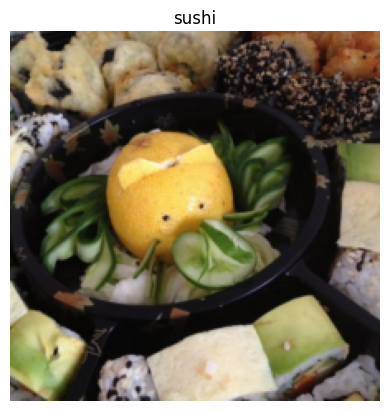

In [9]:
# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False)

In [10]:
height = 224 # H
width = 224 # W
color_channels = 3 # C
patch_size = 16 # P

number_of_patches = int((height * width) / (patch_size ** 2))
print(f"Number of patches (N) with image height (H={height}), width (W={width}), and patch size (P={patch_size}): {number_of_patches}")

Number of patches (N) with image height (H=224), width (W=224), and patch size (P=16): 196


In [11]:
embedding_layer_input_shape = (height, width, color_channels)
embedding_layer_output_shape = (number_of_patches, patch_size ** 2 * color_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 2D image): {embedding_layer_output_shape}")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 2D image): (196, 768)


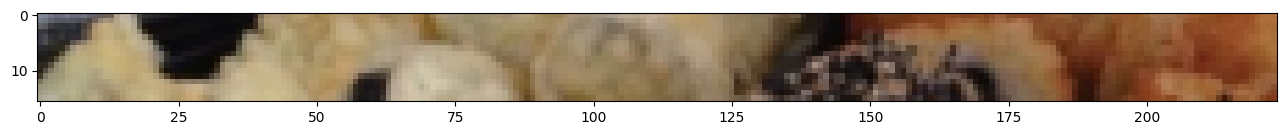

In [12]:
# Change image shape to be compatible with matplotlib (color_channels, height, width) -> (height, width, color_channels)
image_permuted = image.permute(1, 2, 0)

# Index to plot the top row of patched pixels
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :])

In [13]:
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image must be divisible by patch size"

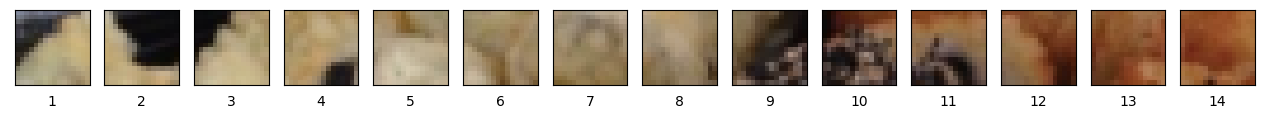

In [14]:
fig, axs = plt.subplots(
    nrows=1, 
    ncols=img_size // patch_size,
    sharex=True, 
    sharey=True,
    figsize=(patch_size, patch_size)
)

for i, patch in enumerate(range(0, img_size, patch_size)):
    axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :])
    axs[i].set_xlabel(i+1)
    axs[i].set_xticks([])
    axs[i].set_yticks([])

Number of patches per row: 14.0        
Number of patches per column: 14.0        
Total patches: 196.0        
Patch size: 16 pixels x 16 pixels


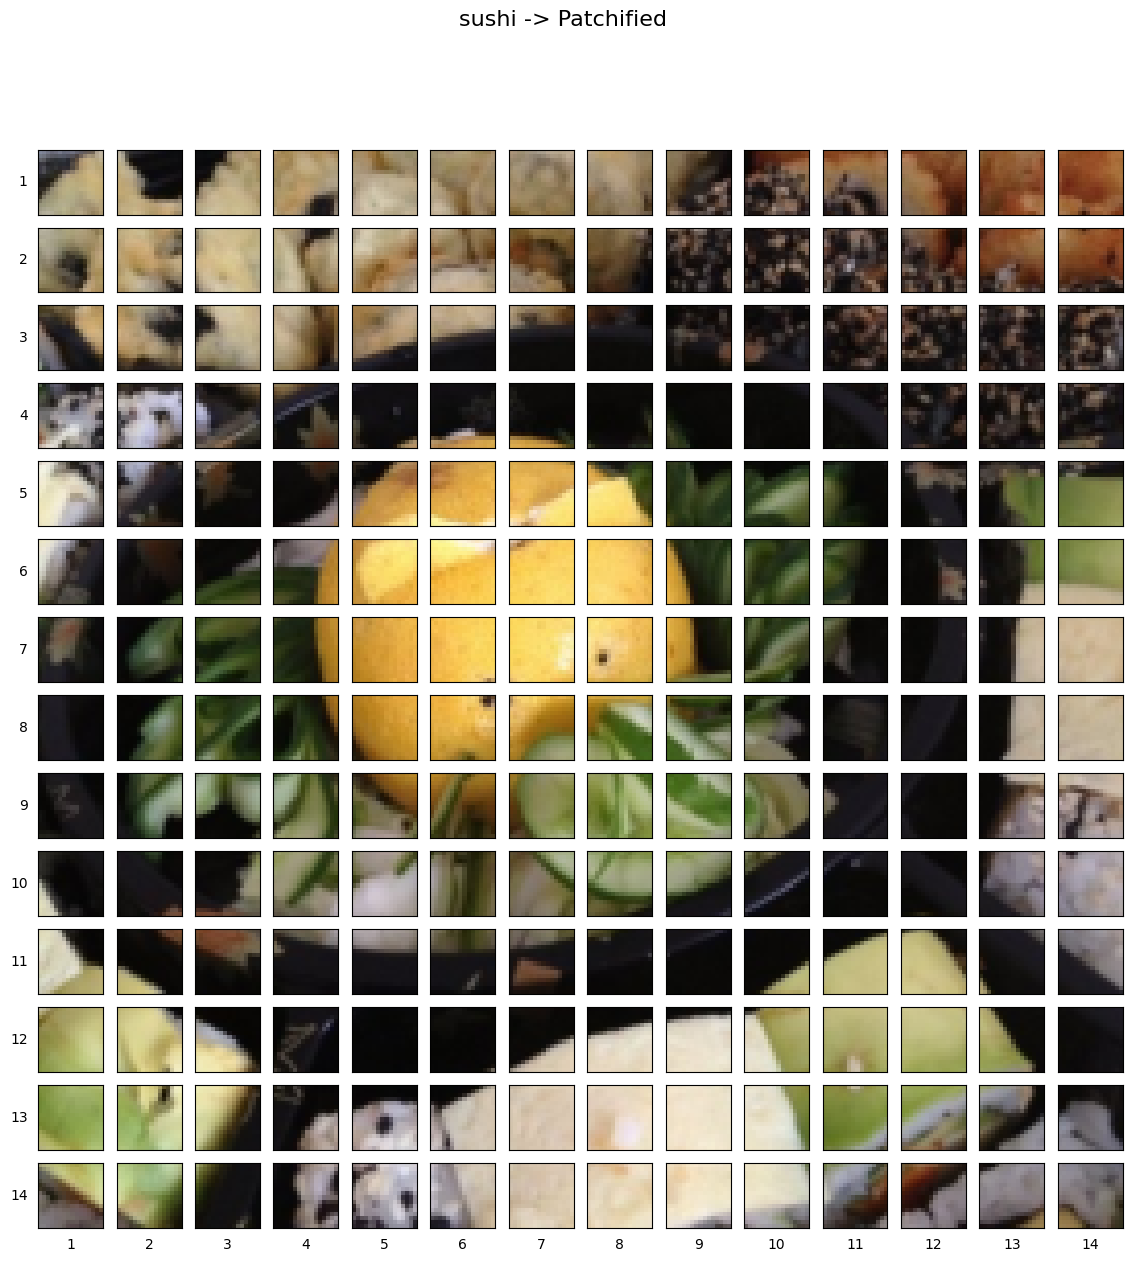

In [15]:
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\
        \nNumber of patches per column: {num_patches}\
        \nTotal patches: {num_patches*num_patches}\
        \nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=img_size // patch_size, # need int not float
                        ncols=img_size // patch_size,
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Loop through height and width of image
for i, patch_height in enumerate(range(0, img_size, patch_size)): # iterate through height
    for j, patch_width in enumerate(range(0, img_size, patch_size)): # iterate through width

        # Plot the permuted image patch (image_permuted -> (Height, Width, Color Channels))
        axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size, # iterate through height
                                        patch_width:patch_width+patch_size, # iterate through width
                                        :]) # get all color channels

        # Set up label information, remove the ticks for clarity and set labels to outside
        axs[i, j].set_ylabel(i+1,
                             rotation="horizontal",
                             horizontalalignment="right",
                             verticalalignment="center")
        axs[i, j].set_xlabel(j+1)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()

# Set a super title
fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=16)
plt.show()

In [16]:
from torch import nn 

patch_size = 16 

# Create the Conv2d layer with hyperparamerters form the ViT paper
conv2d = nn.Conv2d(
    in_channels=3,
    out_channels=768,
    kernel_size=patch_size, 
    stride=patch_size,
    padding=8
)

In [17]:
# Pass one image through the convolutional layer
image_out_of_conv = conv2d(image.unsqueeze(0)) # add a single batch dimension to it
print(image_out_of_conv.shape)

torch.Size([1, 768, 15, 15])


torch.Size([1, 768, 15, 15]) -> [batch_size, embedding_dim, feature_map_height, feature_map_width]

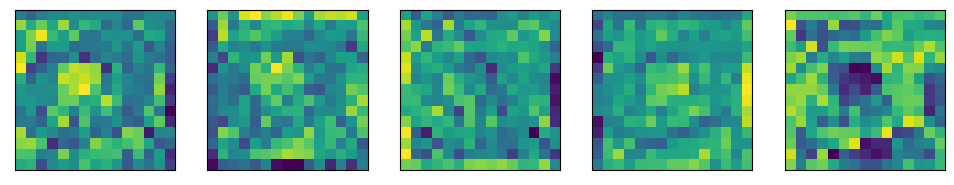

In [23]:
# Plot 5 random convolutional feature maps 
import random 
random_indexes = random.sample(range(0, 758), k=5)

fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

for i, idx in enumerate(random_indexes):
    image_conv_feature_map = image_out_of_conv[:, idx, :, :] # inex on the output tensr of the convolutional layer
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [25]:
# Get a single feature map in tensor form
single_feature_map = image_out_of_conv[:, 0, :, :]
single_feature_map, single_feature_map.requires_grad

(tensor([[[ 0.0510,  0.3007, -0.0045,  0.2147,  0.2777,  0.1967,  0.2370,
            0.2464,  0.1991,  0.0850,  0.1349,  0.1633,  0.1175,  0.1015,
            0.0047],
          [ 0.3164,  0.6570,  0.5740,  0.7968,  0.5084,  0.6467,  0.4077,
            0.4518,  0.4023,  0.2957,  0.2773,  0.3142,  0.2457,  0.3901,
            0.2488],
          [ 0.1705,  0.5585,  0.5205,  0.8356,  0.4497,  0.6379,  0.6247,
            0.3565,  0.1906,  0.2080,  0.1662,  0.2895,  0.2167,  0.2941,
            0.1635],
          [ 0.1374,  0.3641,  0.4982,  0.4447,  0.2000,  0.1086,  0.0774,
            0.0410,  0.0224,  0.0506,  0.0758,  0.2027,  0.0811,  0.2004,
            0.1708],
          [ 0.4381,  0.4701,  0.4194,  0.1593,  0.2128,  0.2384,  0.4819,
            0.3817,  0.0849,  0.0788,  0.1029,  0.0285,  0.1004,  0.2589,
            0.0302],
          [ 0.4167,  0.3863,  0.0829,  0.1285,  0.4824,  0.8274,  0.8231,
            0.8978,  0.6044,  0.2412,  0.2472,  0.0621,  0.1117,  0.4482,
       

In [26]:
# Current tensor shape
print(f"Current tensor shape: {image_out_of_conv.shape} -> [batch, embedding_dim, feature_map_height, feature_map_width]")

Current tensor shape: torch.Size([1, 768, 15, 15]) -> [batch, embedding_dim, feature_map_height, feature_map_width]


In [27]:
# Create flatten layer
flatten = nn.Flatten(
    start_dim=2, # flatten feature_map_height (dimension 2)
    end_dim=3  # flatten feature_map_width (dimension 3)
) 

In [28]:
image_out_of_conv_flattened = flatten(image_out_of_conv)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")

Flattened image feature map shape: torch.Size([1, 768, 225])


In [29]:
# Get flattened image patch embeddings in right shape
image_out_of_conv_flattened_reshaped = image_out_of_conv_flattened.permute(0, 2, 1) # [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]
print(f"Patch embedding sequence shape: {image_out_of_conv_flattened_reshaped.shape} -> [batch_size, num_patches, embedding_size]")

Patch embedding sequence shape: torch.Size([1, 225, 768]) -> [batch_size, num_patches, embedding_size]


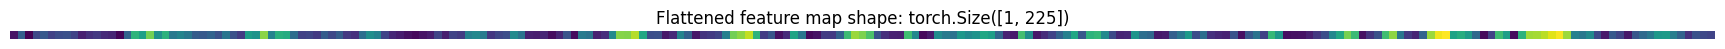

In [30]:
# Get a single flattened feature map
single_flattened_feature_map = image_out_of_conv_flattened_reshaped[:, :, 0] # index: (batch_size, number_of_patches, embedding_dimension)

# Plot the flattened feature map visually
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False);

In [31]:
# See the flattened feature map as a tensor
single_flattened_feature_map, single_flattened_feature_map.requires_grad, single_flattened_feature_map.shape

(tensor([[ 0.0510,  0.3007, -0.0045,  0.2147,  0.2777,  0.1967,  0.2370,  0.2464,
           0.1991,  0.0850,  0.1349,  0.1633,  0.1175,  0.1015,  0.0047,  0.3164,
           0.6570,  0.5740,  0.7968,  0.5084,  0.6467,  0.4077,  0.4518,  0.4023,
           0.2957,  0.2773,  0.3142,  0.2457,  0.3901,  0.2488,  0.1705,  0.5585,
           0.5205,  0.8356,  0.4497,  0.6379,  0.6247,  0.3565,  0.1906,  0.2080,
           0.1662,  0.2895,  0.2167,  0.2941,  0.1635,  0.1374,  0.3641,  0.4982,
           0.4447,  0.2000,  0.1086,  0.0774,  0.0410,  0.0224,  0.0506,  0.0758,
           0.2027,  0.0811,  0.2004,  0.1708,  0.4381,  0.4701,  0.4194,  0.1593,
           0.2128,  0.2384,  0.4819,  0.3817,  0.0849,  0.0788,  0.1029,  0.0285,
           0.1004,  0.2589,  0.0302,  0.4167,  0.3863,  0.0829,  0.1285,  0.4824,
           0.8274,  0.8231,  0.8978,  0.6044,  0.2412,  0.2472,  0.0621,  0.1117,
           0.4482,  0.3083,  0.0558,  0.1468,  0.1689,  0.2012,  0.4350,  0.7954,
           0.836

In [35]:
class PatchEmbedding(nn.Module):
    """Turns a 2D input image into a 1D sequence learnable embedding vector.

    Args:
        in_channels (int): Number of color channels for the input images. Defaults to 3.
        patch_size (int): Size of patches to convert input image into. Defaults to 16.
        embedding_dim (int): Size of embedding to turn image into. Defaults to 768.
    """

    def __init__(
            self,
            in_channels: int=3,
            patch_size: int=16,
            embedding_dim: int=768
    ):
        super().__init__()
        
        self.patcher = nn.Conv2d(
            in_channels=in_channels,
            out_channels=embedding_dim,
            kernel_size=patch_size,
            stride=patch_size,
            padding=0
        )

        self.flatten = nn.Flatten(
            start_dim=2,
            end_dim=3
        )

    def forward(self, x):
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, f"Input image size must be divisibe by patch_size, image shape: {image_resolution}, patch_size: {patch_size}"

        # Perform the forward pass 
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)
        return x_flattened.permute(0, 2, 1)

In [36]:
set_seeds()

# Create an instance of patch embedding layer
patchify = PatchEmbedding(
    in_channels=3,
    patch_size=16,
    embedding_dim=768
)

# Pass a single image through
print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0)) # add an extra batch dimension on the 0th index, otherwise will error
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 768])


In [37]:
# View the patch embedding and patch embedding shape
print(patch_embedded_image)
print(f"Patch embedding shape: {patch_embedded_image.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[-0.5788,  0.2294, -0.1603,  ...,  0.5004, -0.2286,  0.0664],
         [-0.1771, -0.0984, -0.3091,  ...,  0.1363, -0.1440,  0.4644],
         [-0.6797,  0.1858, -0.2269,  ...,  0.4898, -0.0826,  0.1007],
         ...,
         [-0.1431,  0.1060, -0.3615,  ...,  0.3641, -0.1742,  0.0573],
         [-0.6518,  0.1068, -0.0027,  ...,  0.2633, -0.2251,  0.1264],
         [-0.3961,  0.1192, -0.1481,  ...,  0.4069, -0.2904,  0.1459]]],
       grad_fn=<PermuteBackward0>)
Patch embedding shape: torch.Size([1, 196, 768]) -> [batch_size, number_of_patches, embedding_dimension]
